In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-health-and-development-2012-2021/global_health.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/global-health-and-development-2012-2021/global_health.csv')
#print(df.head(20))
print(df.info())
print(df.isna().sum())

# correlation map
corr_matrix = df.drop(['Country','Country_Code'], axis=1).corr(method='pearson', min_periods=1)
"""
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, 
            annot=True,     
            cmap='coolwarm',
            center=0,       
            vmin=-1, 
            vmax=1,
            square=True)    
plt.title('Pearson Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         1880 non-null   object 
 1   Country_Code                    1880 non-null   object 
 2   Year                            1880 non-null   int64  
 3   Fertility_Rate                  1844 non-null   float64
 4   Urban_Population_Percent        1880 non-null   float64
 5   Total_Population                1880 non-null   float64
 6   Water_Access_Percent            1225 non-null   float64
 7   Unemployment_Rate               1740 non-null   float64
 8   Sanitary_Expense_Per_GDP        1834 non-null   float64
 9   Life_Expectancy                 1840 non-null   float64
 10  Life_Expectancy_Female          1840 non-null   float64
 11  Life_Expectancy_Male            1840 non-null   float64
 12  Infant_Deaths                   18

"\nplt.figure(figsize=(20, 16))\nsns.heatmap(corr_matrix, \n            annot=True,     \n            cmap='coolwarm',\n            center=0,       \n            vmin=-1, \n            vmax=1,\n            square=True)    \nplt.title('Pearson Correlation Heatmap')\nplt.xticks(rotation=45, ha='right')\nplt.tight_layout()\nplt.show()\n"

In [3]:
threshold = 0.5
significant_corr = (corr_matrix["Safe_Water_Access_Percent"].abs() > threshold) & (corr_matrix["Safe_Water_Access_Percent"] != 1)
filtered_columns = corr_matrix.columns[significant_corr]

y = pd.DataFrame(df["Safe_Water_Access_Percent"].dropna())
filtered_df = y.join(df[filtered_columns], how='left')
"""
plt.figure(figsize=(10, 7))
plt.barh(filtered_df.columns, filtered_df.isna().mean()*100)
plt.title('Percentage N/A values Distribution')
plt.xlabel('Percentage')
plt.show()
"""

"\nplt.figure(figsize=(10, 7))\nplt.barh(filtered_df.columns, filtered_df.isna().mean()*100)\nplt.title('Percentage N/A values Distribution')\nplt.xlabel('Percentage')\nplt.show()\n"

In [4]:
# For missing data < 5% we use the Simple mean/median imputation. But first drop all NAN to see
# if which value(mean or median) should impute
# For missing data > 30% we remove the affected columns.
clean_df_dropna = filtered_df.dropna()
#print(clean_df_dropna.describe())
"""
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.ravel()
columns_to_plot = ["Fertility_Rate", "Life_Expectancy", "Life_Expectancy_Female", "Life_Expectancy_Male", "Obesity_Rate_Percent", "Underweight_Rate_Percent", "Overweight_Rate_Percent"]
for i, col in enumerate(columns_to_plot):
    sns.histplot(clean_df_dropna[col], kde=True, ax=axes[i], label=col)
plt.tight_layout()
plt.show()
"""

'\nfig, axes = plt.subplots(4, 2, figsize=(15, 10))\naxes = axes.ravel()\ncolumns_to_plot = ["Fertility_Rate", "Life_Expectancy", "Life_Expectancy_Female", "Life_Expectancy_Male", "Obesity_Rate_Percent", "Underweight_Rate_Percent", "Overweight_Rate_Percent"]\nfor i, col in enumerate(columns_to_plot):\n    sns.histplot(clean_df_dropna[col], kde=True, ax=axes[i], label=col)\nplt.tight_layout()\nplt.show()\n'

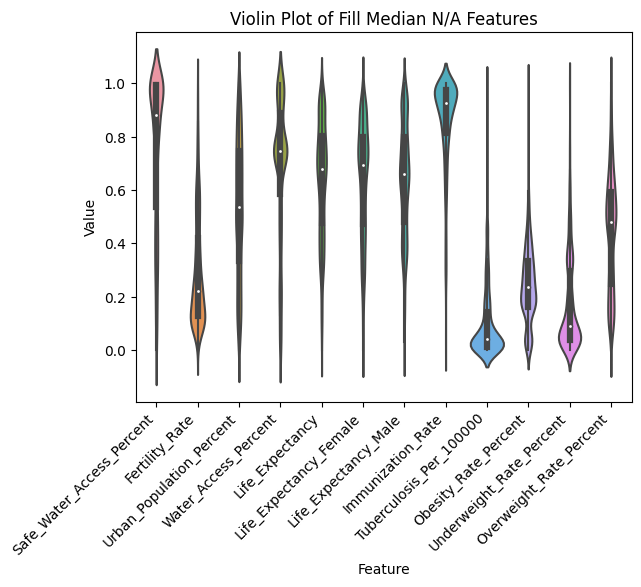

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
clean_df_median = filtered_df.fillna(filtered_df.median())
scaler = MinMaxScaler()

clean_df_median_Norm = pd.DataFrame(scaler.fit_transform(clean_df_median), columns=clean_df_median.columns)
clean_df_median_melt = clean_df_median_Norm.melt(var_name="Feature", value_name="Value")
sns.violinplot(x="Feature", y="Value", data=clean_df_median_melt)
plt.title("Violin Plot of Fill Median N/A Features")
plt.xticks(rotation=45, ha='right')
plt.show()